In [1]:
### Change Point Model ###
from change_detection import ChangePointDetector
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append('../../../')
from main import Manager 
m = Manager('../../../')
from bin.plots.volume_oi_chart import price_volume_oi_chart
from bin.utils.tools import pretty_print

2025-05-02 13:43:59,169 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-05-02 13:43:59,169 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-05-02 13:43:59,172 - INFO - PriceDB Initialized successfully at 2025-05-02 13:43:59.172423
2025-05-02 13:43:59,172 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-05-02 13:43:59.172423
2025-05-02 13:43:59,172 - INFO - Established 3 database connections
2025-05-02 13:43:59,172 - bin.price.db_connect - INFO - Established 3 database connections
2025-05-02 13:43:59,245 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


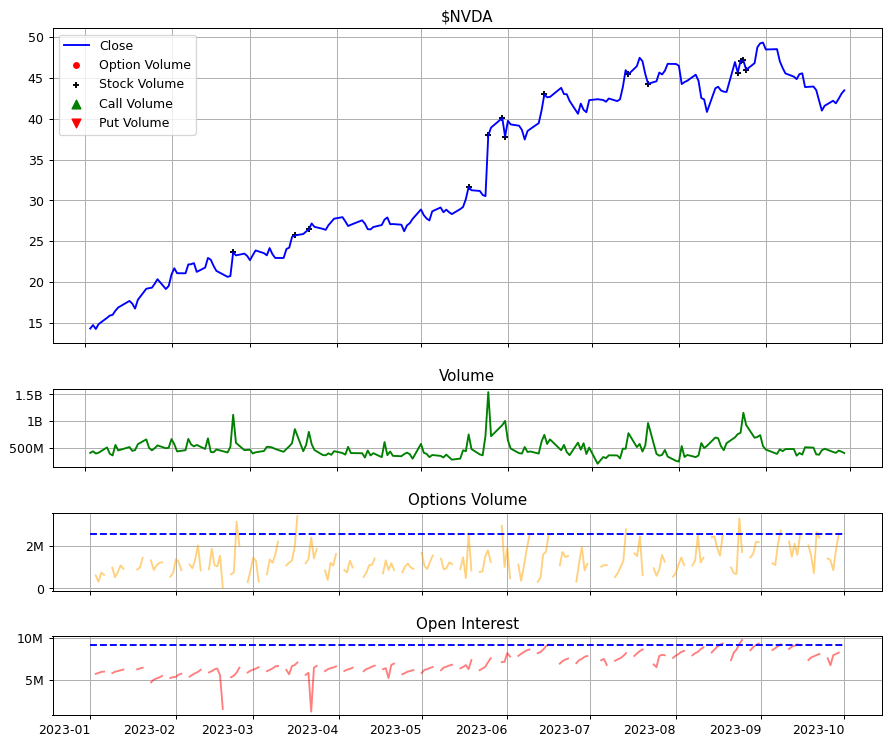

In [3]:
def get_aligned(stock):
    price_df = m.Pricedb.ohlc(stock)
    price_df =price_df.copy().sort_index()
    d = m.Optionsdb.get_daily_option_stats(stock).sort_index()
    d = d.resample('1D').sum()
    price_df = price_df.loc[d.index[0]:]
    d = d.replace(0, np.nan)
    return price_df, d

def show_volume_oi(stock, start_date = None, end_date = None):
    pdf, odf = get_aligned(stock)
    pdf.columns = [x.lower() for x in pdf.columns]
    fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
    price_volume_oi_chart(odf, pdf, fig, ax, stock = stock, start_date=start_date, end_date=end_date)
    fig.show()
    return pdf, odf

_, _ = show_volume_oi('nvda', '2023-01-01', '2023-10-01')

In [4]:
from trend_results import TResults
tr = TResults(
    connections = '../../../',
    lookback_days= 90,
    window_size = 200, 
    period = 30
    
    )


2025-05-02 13:43:59,997 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-05-02 13:43:59,997 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-05-02 13:43:59,999 - INFO - PriceDB Initialized successfully at 2025-05-02 13:43:59.999512
2025-05-02 13:43:59,999 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-05-02 13:43:59.999512
2025-05-02 13:43:59,999 - INFO - Established 3 database connections
2025-05-02 13:43:59,999 - bin.price.db_connect - INFO - Established 3 database connections
2025-05-02 13:44:00,096 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [5]:
results = tr.analyze_stocks()

Processing nvo: 100%|██████████| 184/184 [00:45<00:00,  4.04it/s, Success=1]


In [15]:
# Convert to DataFrame
data = []
for i in results:
    for result in i:
        data.append({
            'stock': result.stock,
            'metric': result.name,
            'trend_direction': result.trend_direction,
            'seasonality': result.seasonality,
            'slope': result.slope,
            'change_point': result.change_point
        })
df = pd.DataFrame(data)

# Flag slope discrepancies (where trend direction and slope sign don't match)
df['slope_discrepancy'] = ((df['trend_direction'] == 'up') & (df['slope'] < 0)) | ((df['trend_direction'] == 'down') & (df['slope'] > 0))
print("DataFrame with Slope Discrepancies Flagged:")
df[df.slope_discrepancy == True]

DataFrame with Slope Discrepancies Flagged:


,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
2,gdx,options_volume,up,normal,-0.000924,0.0,True
6,gdx,put_oi,up,low,-0.000827,0.0,True
8,gdx,put_volume,up,normal,-0.000701,1.0,True
9,gme,close_prices,up,normal,-0.002637,1.0,True
11,gme,options_volume,up,normal,-0.000411,1.0,True
...,...,...,...,...,...,...,...
1574,tost,put_volume,down,high,0.000998,0.0,True
1577,pct,options_volume,down,normal,0.090091,1.0,True
1582,pct,call_volume,down,normal,0.093507,1.0,True
1583,pct,put_volume,down,normal,0.086873,0.0,True


In [16]:
df.metric.unique()

array(['close_prices', 'stock_volume', 'options_volume', 'oi', 'atm_iv',
       'call_oi', 'put_oi', 'call_volume', 'put_volume'], dtype=object)

In [17]:
increasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_oi = df[(df.metric == 'call_oi') & (df.trend_direction == 'up')].stock.tolist()
decreasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'down')].stock.tolist()

increasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_volume = df[(df.metric == 'call_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'down')].stock.tolist()


def print_10_items_per_line(title, lst):
    print(title)
    print("=====================================")
    for i in range(0, len(lst), 10):
        print(", ".join(lst[i:i+10]))


print_10_items_per_line("Increasing OI:", list(set(increasing_oi + increasing_price)))
print_10_items_per_line("Increasing Call OI:", list(set(increasing_call_oi + increasing_price)))

Increasing OI:
pgr, amzn, smh, aal, sony, fxy, arm, mu, ttd, qcom
jets, run, v, mo, vale, hsbc, dell, ba, ief, cvx
btu, afl, cvs, pct, bil, wfc, k, tsla, bno, sol
meta, aa, tsn, slv, uvxy, pfe, clx, ko, jpm, tmv
kre, dltr, f, intu, tgt, dis, afrm, tbt, cag, aapl
gdx, xrt, kr, xly, dkng, lmt, gsl, shy, mpw, lqd
rkt, abbv, u, pbw, fang, qqq, x, iei, itb, xom
oxy, hood, sono, eog, weat, xlb, c, gld, mos, gme
icln, lulu, aig, mdb, xlre, nflx, amat, ge, vxx, wba
xlp, xlk
Increasing Call OI:
pgr, smh, aal, sony, fxy, arm, mu, ttd, qcom, jets
run, v, mo, ctra, vale, bito, hsbc, dell, ba, ief
cvx, btu, afl, cvs, pct, bil, wfc, k, bno, sol
meta, aa, tsn, xle, slv, uvxy, sofi, clx, rddt, moo
ko, xlc, jpm, spy, tmv, kre, dltr, f, intu, tgt
dis, afrm, tbt, cag, aapl, gdx, xrt, kr, xly, dkng
lmt, shy, mpw, rkt, abbv, u, pbw, qqq, x, orcl
iei, itb, oxy, hood, sono, eog, weat, xlb, c, gld
mos, gme, iwm, icln, lulu, aig, mdb, xlre, nflx, amat
ge, vxx, wba, xlp


In [18]:
print_10_items_per_line("Decreasing Options Volume:", decreasing_options_volume)
print_10_items_per_line("Decreasing Price Volume:", decreasing_price_volume)

Decreasing Options Volume:
amzn, spy, xlf, aapl, uber, xli, uup, pep, goog, ntr
dkng, mdb, xlu, ups, pltr, vxx, wmt, cvx, fcel, vale
mo, intc, mu, hd, rrc, fdn, lc, vuzi, bkkt, lmt
wfc, crwd, mrk, baba, tsla, sol, mos, qs, msft, tgt
meta, rblx, qqq, iei, ccj, xme, ebay, f, pypl, ibm
xly, amd, amc, xle, xom, xlk, xlv, bito, clsk, coin
lqd, asan, sbux, jets, tlt, xlc, hsbc, kr, afrm, gsl
wba, ung, ba, cmre, intu, snap, nvda, ctva, corn, dis
csco, ko, ctra, snow, li, run, roku, iwm, oxy, c
abnb, v, x, mara, clx, jpm, k, sony, hood, pho
cag, uvxy, bil, ual, pgr, afl, aig, avgo, sofi, mpw
dia, arm, ttd, amat, dash, open, dbx, panw, tdoc, smci
hims, cava, expe, rddt, dell, dltr, adbe, orcl, u, tost
pct, oklo, tem
Decreasing Price Volume:


In [19]:
b = set(increasing_options_volume) & set(increasing_price) & set(increasing_call_volume) & set(increasing_call_oi)
print(b)

{'tbt', 'rkt', 'icln', 'ief', 'gld', 'gme', 'tmv', 'fxy', 'shy', 'tsn'}


,total_vol,call_vol_chng,put_vol_chng,total_oi,call_oi_chng,put_oi_chng
date,,,,,,
2025-04-28,"104,468.00","-2,866.00","1,460.00","1,186,114.00","23,604.00","26,076.00"
2025-04-29,"98,430.00","-5,232.00",650.00,"1,200,058.00","12,396.00","1,548.00"
2025-04-30,"81,159.00","-13,080.00","-5,941.00","1,212,800.00","11,158.00","1,584.00"
2025-05-01,"89,429.00","9,712.00","2,627.00","1,217,358.00","1,920.00","2,638.00"
2025-05-02,"46,117.00","2,279.00","-3,686.00","616,572.00","4,796.00","3,097.00"


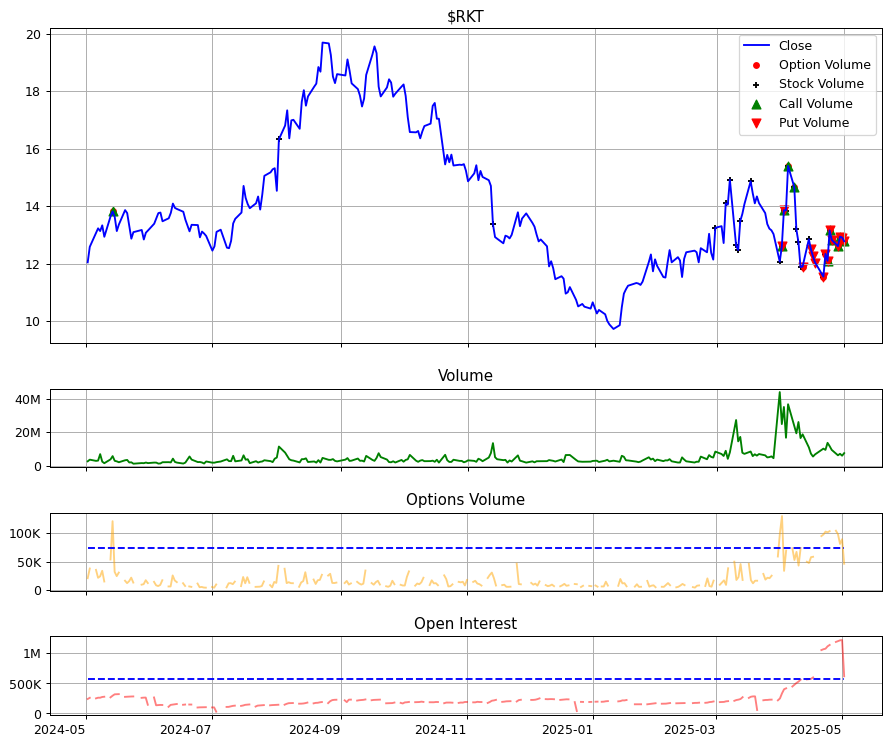

In [20]:
_, odf = show_volume_oi('rkt','2024-05-02')

pretty_print(odf[['total_vol', 'call_vol_chng', 'put_vol_chng', 'total_oi', 'call_oi_chng', 'put_oi_chng']].tail())

In [32]:

change_df = df[df.change_point == 1]
call_volume_change = list(change_df[change_df.metric.isin(['call_volume'])].stock.unique())
put_volume_change = list(change_df[change_df.metric.isin(['put_volume'])].stock.unique())
print_10_items_per_line('Call Change Points',call_volume_change)

Call Change Points
gme, amzn, spy, xli, intc, slv, tsla, msft, rkt, qqq
iei, xlb, nvda, run, gld, x, sony, hood, spot, bil
avgo, hims, rddt, fxy, dltr, pct, oklo, tem, btu


,total_vol,total_prem,total_oi,call_vol,put_vol,call_oi,put_oi,call_iv,put_iv,atm_iv,...,call_oi_chng,put_oi_chng,call_iv_chng,put_iv_chng,atm_iv_chng,otm_iv_chng,call_vol_pct_chng,put_vol_pct_chng,call_oi_pct_chng,put_oi_pct_chng
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,511975.0,1.174557e+08,11276824.0,375923.0,136052.0,6917674.0,4359150.0,1.107583,0.999617,0.537928,...,2242474.0,1216594.0,0.065367,0.047663,0.049731,-0.362986,0.274427,-0.274427,0.030837,-0.030837
2025-04-29,294597.0,1.177048e+08,11401286.0,195855.0,98742.0,6998504.0,4402782.0,1.022218,1.005308,1.013737,...,80830.0,43632.0,-0.043248,-0.013414,-0.062119,-0.004495,-0.112633,0.112633,0.000786,-0.000786
2025-04-30,357981.0,1.217863e+08,11461318.0,216961.0,141020.0,7029674.0,4431644.0,1.041660,0.990605,1.000527,...,31170.0,28862.0,0.003120,0.061515,0.008411,0.068581,-0.110451,0.110451,-0.000991,0.000991
2025-05-01,288495.0,1.199550e+08,11589622.0,170197.0,118298.0,7092592.0,4497030.0,1.009133,0.975637,NaN,...,62918.0,65386.0,-0.051755,0.015042,NaN,0.065780,-0.103260,0.103260,-0.002722,0.002722
2025-05-02,110187.0,5.967438e+07,5821085.0,63251.0,46936.0,3567178.0,2253907.0,0.559135,0.450570,0.459600,...,20882.0,5392.0,0.031179,-0.013628,NaN,-0.034611,-0.089477,0.089477,0.000825,-0.000825


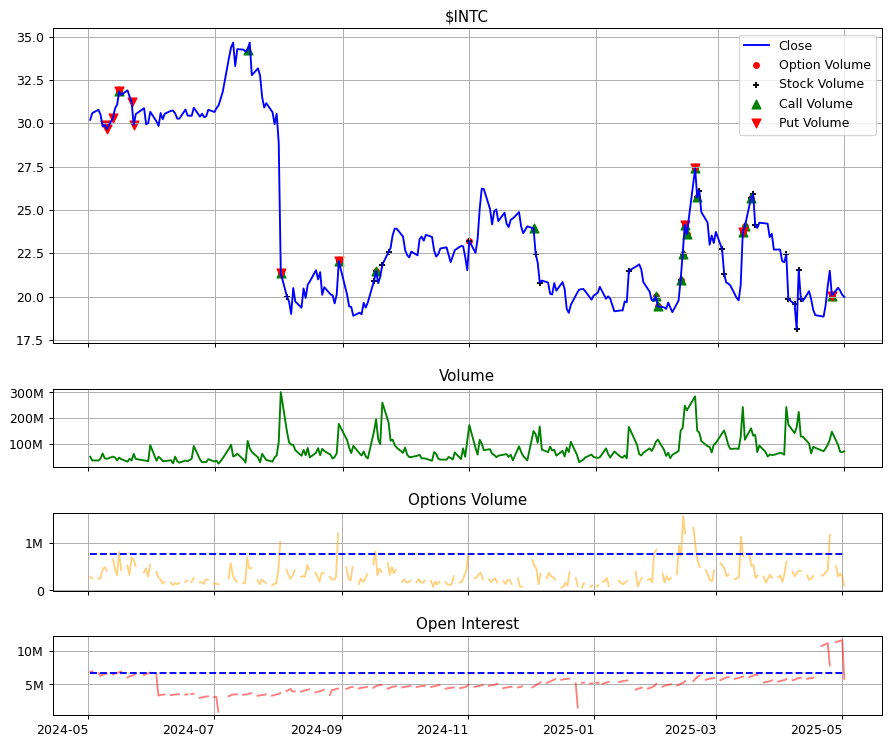

In [34]:
_, b = show_volume_oi('intc','2024-05-02')
b.tail()

In [31]:
df

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
0,gdx,close_prices,up,normal,0.004920,1.0,False
1,gdx,stock_volume,up,low,0.005929,1.0,False
2,gdx,options_volume,up,normal,-0.000924,0.0,True
3,gdx,oi,down,low,-0.000807,0.0,False
4,gdx,atm_iv,up,low,0.000254,1.0,False
...,...,...,...,...,...,...,...
1606,btu,atm_iv,up,normal,0.034944,1.0,False
1607,btu,call_oi,up,normal,0.013827,1.0,False
1608,btu,put_oi,up,normal,0.012465,1.0,False
1609,btu,call_volume,up,low,0.016006,1.0,False
